<a href="https://colab.research.google.com/github/nkurinsky/THz-FTS/blob/master/python/Notebooks/DataAna/FTS_Analysis_DecemberPowerSupply.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal of this file is an attempt at using an arbitrary list of frequencies for as the inputs the blackbody signal. This would resolve an issue where the total power is not correct due to different sized integration slices and separation between evaluation points. This file was created on April 16, 2020.

In [76]:
from pylab import *
from scipy import fft
import matplotlib.pyplot as plt
from scipy.signal import periodogram as psd
from scipy.signal import get_window
import numpy as np
from scipy.signal import find_peaks
from math import sqrt, sin
from cmath import pi
import pandas as pd
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

%matplotlib inline

In [77]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [78]:
import sys
sys.path.append('/content/drive/My Drive/BREAD Experiment/FTS Modeling/lib/')
from BlackbodyFunctions import *
from FTSFunctions import *

Motorized stage details (https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=2163): 


*   Max Velocity = 2.6 mm/s
*   Max Travel Range = 12mm (12e3 µm)
*   Minimum Step Size = 0.10 µm

Review this document for understanding of how FTS works/ data looks: https://chem.libretexts.org/Bookshelves/Physical_and_Theoretical_Chemistry_Textbook_Maps/Supplemental_Modules_(Physical_and_Theoretical_Chemistry)/Spectroscopy/Fundamentals_of_Spectroscopy/The_Power_of_the_Fourier_Transform_for_Spectroscopists

In [79]:
#define some useful constants
c_micron_per_second = 3e8 * 1e6
Hz_to_THz = 1e-12
mm_to_micron = 1000
nm_to_micron = 1/1000

noise_to_signal_ratio = 1e-7

In [80]:
#fixed variables that we can use for generating the background blackbody signal
lambda_or_nu = False
min_frequency = 0.1 #THz
max_frequency = 1500 #THz
frequency_slice_size = 0.01  #THz 
frequencies = arange(frequency_slice_size, max_frequency, frequency_slice_size) #still in THz (use min as frequency slice size)

In [81]:
############Extract the temperature as a function of voltage information to input most accurate data into the blackbody simulation##########
folder_path = '/content/drive/My Drive/BREAD Experiment/Data Taking/'
Si253_temp_manual = pd.read_csv(folder_path + "Voltage Vs. Temp (various sources)/Si253_temp_manual.csv")
Si253_temp_manual_1 = pd.read_csv(folder_path + "Voltage Vs. Temp (various sources)/Si253_temp_manual_1.csv")
Si253_temp_manual_2 = pd.read_csv(folder_path + "Voltage Vs. Temp (various sources)/Si253_temp_manual_2.csv")
Si253_temp_manual_3 = pd.read_csv(folder_path + "Voltage Vs. Temp (various sources)/Si253_temp_manual_3.csv")
cleanedTempList = [x for x in Si253_temp_manual['Temp'] if str(x) != 'nan']
cleanedVoltList = [x for x in Si253_temp_manual['Voltage'] if str(x) != 'nan']
cleanedTempList = cleanedTempList[10:] #trim off the first 10 entries from this list because it started at 0.1 V rather than 1.1 V
cleanedVoltList = cleanedVoltList[10:] 
cleanedTempList_short_1 = [x for x in Si253_temp_manual_1['Temp'] if str(x) != 'nan']
cleanedTempList_short_2 = [x for x in Si253_temp_manual_2['Temp'] if str(x) != 'nan']
cleanedTempList_short_3 = [x for x in Si253_temp_manual_3['Temp'] if str(x) != 'nan']
cleanedVoltList_short = [x for x in Si253_temp_manual_1['Voltage'] if str(x) != 'nan']
cleanedTempList_short_0_extrapolate = interp1d(cleanedVoltList, cleanedTempList, fill_value='extrapolate')
cleanedTempList_short_1_extrapolate = interp1d(cleanedVoltList_short, cleanedTempList_short_1, fill_value='extrapolate')
cleanedTempList_short_2_extrapolate = interp1d(cleanedVoltList_short, cleanedTempList_short_2, fill_value='extrapolate')
cleanedTempList_short_3_extrapolate = interp1d(cleanedVoltList_short, cleanedTempList_short_3, fill_value='extrapolate')

def get_temp(volt, manual = False):
  if manual:
    #this returns the manually calculated temperautre value from data taken with thermal camera
    average_temp = (cleanedTempList_short_0_extrapolate(volt) + cleanedTempList_short_1_extrapolate(volt) + cleanedTempList_short_2_extrapolate(volt) + cleanedTempList_short_3_extrapolate(volt))/4
    return (average_temp)
  else: 
    # from the IR-Si253 voltage temperature plot (https://www.boselec.com/wp-content/uploads/Linear/IRSources/IRSourcesLiterature/IR-Si253-Series-formerly-IR-18-and-IR-19.pdf), were able to extract data points and fit to a polynomial using excel. 
    # The equation seen here is the corresponding relationship between voltage (V) and temperature (K)
    # Note that these values are no longer valid after the "plateu" that is seen becasue of the max current in the UPS
    t =  -3.5727 * volt**2 + 136.61*volt + 294.53
    return t

In [82]:
folder_path = '/content/drive/My Drive/BREAD Experiment/Data Taking/Autumn2020Data_NewPowerSupply/'
list_of_files = [
  'data/20nov2020-1500PMthru1600PM-Thorlabs-Laser-635nm-472THz-noFilter-50nmPerSeconds100micronTravel.csv',
  'data/20nov2020-1423PMthru1435PM-Thorlabs-Laser-635nm-472THz-noFilter-50nmPerSeconds50micronTravel.csv',
  'data/20nov2020-1123AMthru1135AM-Thorlabs-Laser-635nm-472THz-noFilter-100nmPerSeconds70micronTravel.csv',
  'data/20nov2020-1111AMthru1125AM-Thorlabs-Laser-635nm-472THz-noFilter-100nmPerSeconds50micronTravel.csv',
  'data/24nov2020-1108AMthru1150PM-IR-Si253-7p6V-1p39A-noFilter-100nmPerSeconds250micronTravel.csv',
  'data/24nov2020-1200PMthru1242PM-IR-Si253-7p6V-1p39A-plasticBagFilter-100nmPerSeconds250micronTravel.csv',
  'data/24nov2020-1245PMthru1328PM-IR-Si253-7p6V-1p39A-noFilter-100nmPerSeconds250micronTravel.csv',
  'data/24nov2020-1332PMthru1415PM-IR-Si253-7p6V-1p39A-PEWFilter-100nmPerSeconds250micronTravel.csv',
  'data/24nov2020-1420PMthru1502PM-IR-Si253-7p6V-1p39A-SiWFilter-100nmPerSeconds250micronTravel.csv',
  'data/24nov2020-1508PMthru1551PM-IR-Si253-7p6V-1p39A-1650nmFilter-100nmPerSeconds250micronTravel.csv',
  'data/25nov2020-0939AMthru1104AM-IR-Si253-7p6V-1p39A-noFilter-100nmPerSeconds500micronTravel.csv',
  'data/25nov2020-1116AMthru1241PM-IR-Si253-7p6V-1p39A-plasticBagFilter-100nmPerSeconds500micronTravel.csv',
  'data/30nov2020-1026AMthru1225PM-IR-Si253-7p6V-1p39A-noFilter-100nmPerSeconds700micronTravel.csv', 
  'data/30nov2020-1229PMthru1427PM-IR-Si253-7p6V-1p39A-plasticBagFilter-100nmPerSeconds700micronTravel.csv',
  'data/30nov2020-1431PMthru1630PM-IR-Si253-7p6V-1p39A-PEWFilter-100nmPerSeconds700micronTravel.csv',
  'data/30nov2020-1636PMthru1835PM-IR-Si253-7p6V-1p39A-SiWFilter-100nmPerSeconds700micronTravel.csv',
  'data/01dec2020-0912AMthru1111AM-IR-Si253-7p6V-1p39A-noFilter-100nmPerSeconds700micronTravel.csv',
  'data/01dec2020-1151AMthru1350PM-IR-Si253-7p6V-1p39A-25micronMeshFilter-100nmPerSeconds700micronTravel.csv',
  'data/01dec2020-1409PMthru1608PM-IR-Si253-7p6V-1p39A-noFilter-100nmPerSeconds700micronTravel.csv',
  'data/02dec2020-0820AMthru1019AM-IR-Si253-7p6V-1p39A-DoublePlasticBagFilter-100nmPerSeconds700micronTravel.csv',
  'data/02dec2020-1049AMthru1248PM-IR-Si253-9p5V-1p46A-noFilter-100nmPerSeconds700micronTravel.csv',
  'data/02dec2020-1254PMthru1453PM-IR-Si253-9p5V-1p46A-plasticBagFilter-100nmPerSeconds700micronTravel.csv',
  'data/04dec2020-0954AMthru1045AM-IR-Si253-9p5V-1p46A-PEWFilter-500nmPerSeconds1500micronTravel.csv',
  'data/04dec2020-1048AMthru1144AM-IR-Si253-9p5V-1p46A-PEWFilter-500nmPerSeconds1700micronTravel.csv',
  'data/04dec2020-1148AMthru1244PM-IR-Si253-9p5V-1p46A-SiWFilter-500nmPerSeconds1700micronTravel.csv',
  'data/04dec2020-1248PMthru1441PM-IR-Si253-9p5V-1p46A-SiWFilter-250nmPerSeconds1700micronTravel.csv',
  'data/04dec2020-1446PMthru1639PM-IR-Si253-9p5V-1p46A-PEWFilter-250nmPerSeconds1700micronTravel.csv',
  'data/07dec2020-0952AMthru1132AM-IR-Si253-9p5V-1p46A-PEWFilter-500nmPerSeconds3000micronTravel.csv',
  'data/07dec2020-1140AMthru1325PM-IR-Si253-9p5V-1p46A-PEWFilter-500nmPerSeconds3000micronTravel.csv',
  'data/07dec2020-1322PMthru1510PM-IR-Si253-9p5V-1p46A-PEWFilter-500nmPerSeconds3000micronTravel.csv',
  'data/07dec2020-1507PMthru1710PM-IR-Si253-9p5V-1p46A-PEWFilter-500nmPerSeconds4000micronTravel.csv',
  'data/08dec2020-1020AMthru1200PM-IR-Si253-9p5V-1p46A-DoublePlasticBagFilter-500nmPerSeconds3000micronTravel.csv',
  'data/08dec2020-1203PMthru1343PM-IR-Si253-9p5V-1p46A-SiWFilter-500nmPerSeconds3000micronTravel.csv',
  'data/08dec2020-1346PMthru1559PM-IR-Si253-9p5V-1p46A-SiWFilter-500nmPerSeconds4000micronTravel.csv',
  'data/09dec2020-0917AMthru1042AM-IR-Si253-10p4V-1p50A-1000nmBandpassFilter-100nmPerSeconds270micronTravel.csv',
  'data/09dec2020-1048AMthru1131AM-IR-Si253-10p6V-1p50A-1000nmBandpassFilter-100nmPerSeconds252p94micronTravel.csv',
  'data/09dec2020-1143AMthru1315PM-IR-Si253-10p6V-1p50A-1650nmBandpassFilter-100nmPerSeconds500micronTravel.csv',
  'data/09dec2020-1311PMthru1435PM-IR-Si253-10p6V-1p50A-1650nmBandpassFilter-100nmPerSeconds500micronTravel.csv', 
  'data/09dec2020-1439PMthru1525PM-IR-Si253-10p6V-1p50A-1000nmBandpassFilter-100nmPerSeconds270micronTravel.csv'
  ]

In [83]:
## extract information from file according to name:
def get_file_parameters(f):  
  #print('Processing {0}'.format(f))

  # Read in CSV file
  df = pd.read_csv(folder_path + f, header=None, usecols=[0,1])

  # Make legend name from file name
  fi = f.split('-')
  source = fi[3]

  if source == "Laser": voltage, current = 0, 0
  else:
    voltage = float(fi[4].replace('p', '.').replace('V', ''))
    current = fi[5].replace('p', '.')
  motion  = fi[7].replace('nmPerSeconds', ' nm/s, ').replace('p', '.').replace('.csv', '')
  source = fi[3]
  filter  = fi[6]
  date = fi[0].replace('data/', '')
  time = fi[1]
  source = '{0}-{1}'.format(fi[2], fi[3])

  if filter == "1650nmFilter": filter = "1650nmBandpassFilter" # fix small error in one filter naming process! 
  case = '{0}_{1}: {2} {3} ({4}V, {5}, {6}) '.format(date, time, source, filter, str(voltage), current,  motion)

  mirrorVelocity = fi[7].split('nm')[0]
  timeToSpace = float(mirrorVelocity) / 1000 # convert seconds to mirror displacement (100 nm / s)

  x = df[0] * timeToSpace
  y = df[1]

  runparameters = [source, voltage, current, filter, motion, date, time, mirrorVelocity]
  return x, y, runparameters, case

In [84]:
all_data  = {}

for f in list_of_files:
  x, y, runparameters, case = get_file_parameters(f)
  all_data.update({case:[x,y,runparameters]})
  print(case)

20nov2020_1500PMthru1600PM: Thorlabs-Laser noFilter (0V, 0, 50 nm/s, 100micronTravel) 
20nov2020_1423PMthru1435PM: Thorlabs-Laser noFilter (0V, 0, 50 nm/s, 50micronTravel) 
20nov2020_1123AMthru1135AM: Thorlabs-Laser noFilter (0V, 0, 100 nm/s, 70micronTravel) 
20nov2020_1111AMthru1125AM: Thorlabs-Laser noFilter (0V, 0, 100 nm/s, 50micronTravel) 
24nov2020_1108AMthru1150PM: IR-Si253 noFilter (7.6V, 1.39A, 100 nm/s, 250micronTravel) 
24nov2020_1200PMthru1242PM: IR-Si253 plasticBagFilter (7.6V, 1.39A, 100 nm/s, 250micronTravel) 
24nov2020_1245PMthru1328PM: IR-Si253 noFilter (7.6V, 1.39A, 100 nm/s, 250micronTravel) 
24nov2020_1332PMthru1415PM: IR-Si253 PEWFilter (7.6V, 1.39A, 100 nm/s, 250micronTravel) 
24nov2020_1420PMthru1502PM: IR-Si253 SiWFilter (7.6V, 1.39A, 100 nm/s, 250micronTravel) 
24nov2020_1508PMthru1551PM: IR-Si253 1650nmBandpassFilter (7.6V, 1.39A, 100 nm/s, 250micronTravel) 
25nov2020_0939AMthru1104AM: IR-Si253 noFilter (7.6V, 1.39A, 100 nm/s, 500micronTravel) 
25nov2020_1116A

In [85]:
def generate_simulation(selected_volt, source, filt, scale_weight = 5e-3, add_weight = 1e-4, for_transmittance=False):
  temp = get_temp(selected_volt)
  filter_check = filt + "Filter"
  filter_val = 0

  if for_transmittance:
    Ls = []
    for key in all_data:
      if all_data[key][2][1] == selected_volt and all_data[key][2][0] == source and all_data[key][2][3] in filter_check: Ls.append(max(all_data[key][0])) #exctract the length traveled of the first function that has the right voltage and source
    L = max(Ls) 
    dx = -1*L/2
    x, y, weights = blackbody_input_function(lambda_or_nu, frequencies, frequency_slice_size, filter="no", dx=dx, L=L, dL=dL,  Temp=temp )

  else:
    Ls = []
    for key in all_data:
      if all_data[key][2][1] == selected_volt and all_data[key][2][0] == source and all_data[key][2][3] in filter_check: Ls.append(max(all_data[key][0])) #exctract the length traveled of the first function that has the right voltage and source
    L = max(Ls)
    dx = -1*L/2
    if filt == "PEW" or filt =="SiW": x, y, weights, filter_val = blackbody_input_function(lambda_or_nu, frequencies, frequency_slice_size, filter=filt, dx=dx, L=L, dL=dL,  Temp=temp )
    elif filt == "1650nmBandpass": x, y, weights, filter_val = blackbody_input_function(lambda_or_nu, frequencies, frequency_slice_size, filter="narrow_1650", dx=dx, L=L, dL=dL,  Temp=temp )
    elif filt == "1000nmBandpass": x, y, weights, filter_val = blackbody_input_function(lambda_or_nu, frequencies, frequency_slice_size, filter="narrow_1000", dx=dx, L=L, dL=dL,  Temp=temp )
    else: x, y, weights = blackbody_input_function(lambda_or_nu, frequencies, frequency_slice_size, filter="no", dx=dx, L=L, dL=dL,  Temp=temp )


  sigma = scale_weight*noise_to_signal_ratio
  y = scale_weight*y + np.random.rand(len(x))*sigma + add_weight
  frequency, spectrum = psd_frequency(y, 'parzen')

  return x, y, frequency, spectrum, filter_val

In [86]:
def plot_transmittance(selected_volt, source, filt, filter_val, spectrum_simulated, scale_weight, add_weight):
  if filt != "PEW" and filt !="SiW" and filt != "1650nmBandpass" and filt != "1000nmBandpass": return #this only works to compare no filter with filter data

  x, y, frequency_simulated_nofilter, spectrum_simulated_nofilter, garbage_filter_val = generate_simulation(selected_volt, source, filt, scale_weight = 5e-3, add_weight = 1e-4, for_transmittance=True)
  filter_check = filt + "Filter"

  c  = 3 * (10 ** 17)  # Speed of light in nm / s
  Rs = 5               # Detector sampling rate

  interpolated_with_filter = []
  interpolated_no_filter = []
  frequency_array = np.arange(0.1,1100, 0.1)
  for key in all_data:
    if all_data[key][2][1] == selected_volt and all_data[key][2][0] == source and all_data[key][2][3]==filter_check: 
      vm = float(all_data[key][2][7]) # Mirror velocity in nm / s (extract from file name)
      print("the mirror velocity for ", key, " is ", str(vm))
      fs_new = (c * Rs ) / (2 * vm * 10 ** 12) # Sampling frequency in THz (factor of 2 is twice path length)
      frequency, spectrum = psd_frequency(all_data[key][1], 'parzen', fs=fs_new)
      inter_filter = interp1d(frequency, spectrum, fill_value='extrapolate')
      interpolated_with_filter.append(inter_filter(frequency_array))

    elif all_data[key][2][1] == selected_volt and all_data[key][2][0] == source and all_data[key][2][3]=="noFilter": 
      vm = float(all_data[key][2][7]) # Mirror velocity in nm / s (extract from file name)
      fs_new = (c * Rs ) / (2 * vm * 10 ** 12) # Sampling frequency in THz (factor of 2 is twice path length)

      frequency, spectrum = psd_frequency(all_data[key][1], 'parzen', fs=fs_new)
      inter_nofilter = interp1d(frequency, spectrum, fill_value='extrapolate')
      interpolated_no_filter.append(inter_nofilter(frequency_array))
  

  # put all fits to one matrix for fast mean calculation
  if len(interpolated_with_filter) == 1: average_filter = interpolated_with_filter[0]
  else:
    all_interpolated_filter = np.vstack(np.array(interpolated_with_filter))
    average_filter = np.average(all_interpolated_filter, axis=0)

  if len(interpolated_no_filter) == 1: average_no_filter = interpolated_no_filter[0]
  else:
    all_interpolated_nofilter = np.vstack(np.array(interpolated_no_filter))
    average_no_filter = np.average(all_interpolated_nofilter, axis=0)
  
  ratio_transform =  np.array(average_filter)/np.array(average_no_filter)

  if len(spectrum_simulated) != len(spectrum_simulated_nofilter):
    frequency_simulated_nofilter = frequency_simulated_nofilter[1:]
    spectrum_simulated_nofilter = spectrum_simulated_nofilter[1:]

  fig = plt.figure(figsize=(8, 6), dpi=150) 
  plt.plot(frequency_simulated_nofilter, spectrum_simulated/spectrum_simulated_nofilter, label = "Filter Bandpass Simulated", color='orange')
  plt.plot(frequency_array, ratio_transform, label = "Filter Bandpass Data (averaged over " + str(len(interpolated_with_filter)) + " trials)", color='C9')
  plt.semilogy(frequencies, filter_val, '--', label = 'Filter Acceptance', color='C6')
  title = filt + " Filter Bandpass as a function of Frequency"
  plt.title(title)
  plt.legend()
  plt.xscale('log')
  plt.grid(True)
  plt.xlim(4e-1, 1100)
  plt.xlabel('Frequency (THz)')
  plt.ylabel("Ratio of Fourier Amplitudes \n of Filter Spectra to Blackbody Speactra")
  return

In [87]:
def plot_details(selected_volt, source, filt, plot_simulation, x_simulated, y_simulated, frequency_simulated, spectrum_simulated):
  filter_check = filt + "Filter"
  temp = get_temp(selected_volt)
  
  fig = plt.figure(figsize=(23, 6), dpi=150)
  plt.subplot(1, 2, 1)
  if plot_simulation: plt.plot(x_simulated, y_simulated, label = "simulated")
  for key in all_data:
    if all_data[key][2][1] == selected_volt and all_data[key][2][0] == source and all_data[key][2][3]==filter_check: plt.plot(all_data[key][0], all_data[key][1], label = all_data[key][2][5] + "_" + all_data[key][2][6] + ": " + all_data[key][2][4])
  
  plt.subplot(1,2,2)
  if plot_simulation: plt.semilogy(frequency_simulated, spectrum_simulated, label = "transform of simulated")
  for key in all_data:
    if all_data[key][2][1] == selected_volt and all_data[key][2][0] == source and all_data[key][2][3]==filter_check:
      frequency, spectrum = psd_frequency(all_data[key][1], 'parzen', fs)
      plt.semilogy(frequency, spectrum, label = "transform of "+ all_data[key][2][5] + ": " + all_data[key][2][4])
  

  #plot details for blackbody spectrum plot
  plt.subplot(1, 2, 1)
  plt.grid(True)
  title = source + " at " + str(selected_volt) + "V (" + str(int(temp)) + "K) Interferometer Signal with " + filt + " filter"
  plt.title(title)
  plt.legend()
  plt.yscale('log')
  plt.xlabel("Optical path difference ($\mu m$)")
  plt.ylabel("Signal Amplitude \n Corresponds to optical power ($\mu W$)")

  # #plot details for fourier transform plot 
  plt.subplot(1, 2, 2)
  plt.title("Transform as a function of Frequency")
  plt.legend()
  plt.grid(True)
  plt.xscale('log')
  plt.xlabel('Frequency (THz)')
  plt.ylabel("Power Density(W/THz)")
  plt.show()
  return 

In [88]:
def plot_data(selected_volt, source, filt, plot_simulation = True, compare_nofilter = False, bandpass = False, scale_weight = 5e-3, add_weight = 1e-4):
  x_simulated, y_simulated, frequency_simulated, spectrum_simulated = 0, 0, 0, 0
  if plot_simulation or bandpass:  x_simulated, y_simulated, frequency_simulated, spectrum_simulated, filter_val = generate_simulation(selected_volt, source, filt, scale_weight=scale_weight, add_weight=add_weight)
  #fill in the plot! 
  plot_details(selected_volt, source, filt, plot_simulation, x_simulated, y_simulated, frequency_simulated, spectrum_simulated)
  if bandpass: plot_transmittance(selected_volt, source, filt, filter_val, spectrum_simulated, scale_weight = 5e-3, add_weight = 1e-4)

  return 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


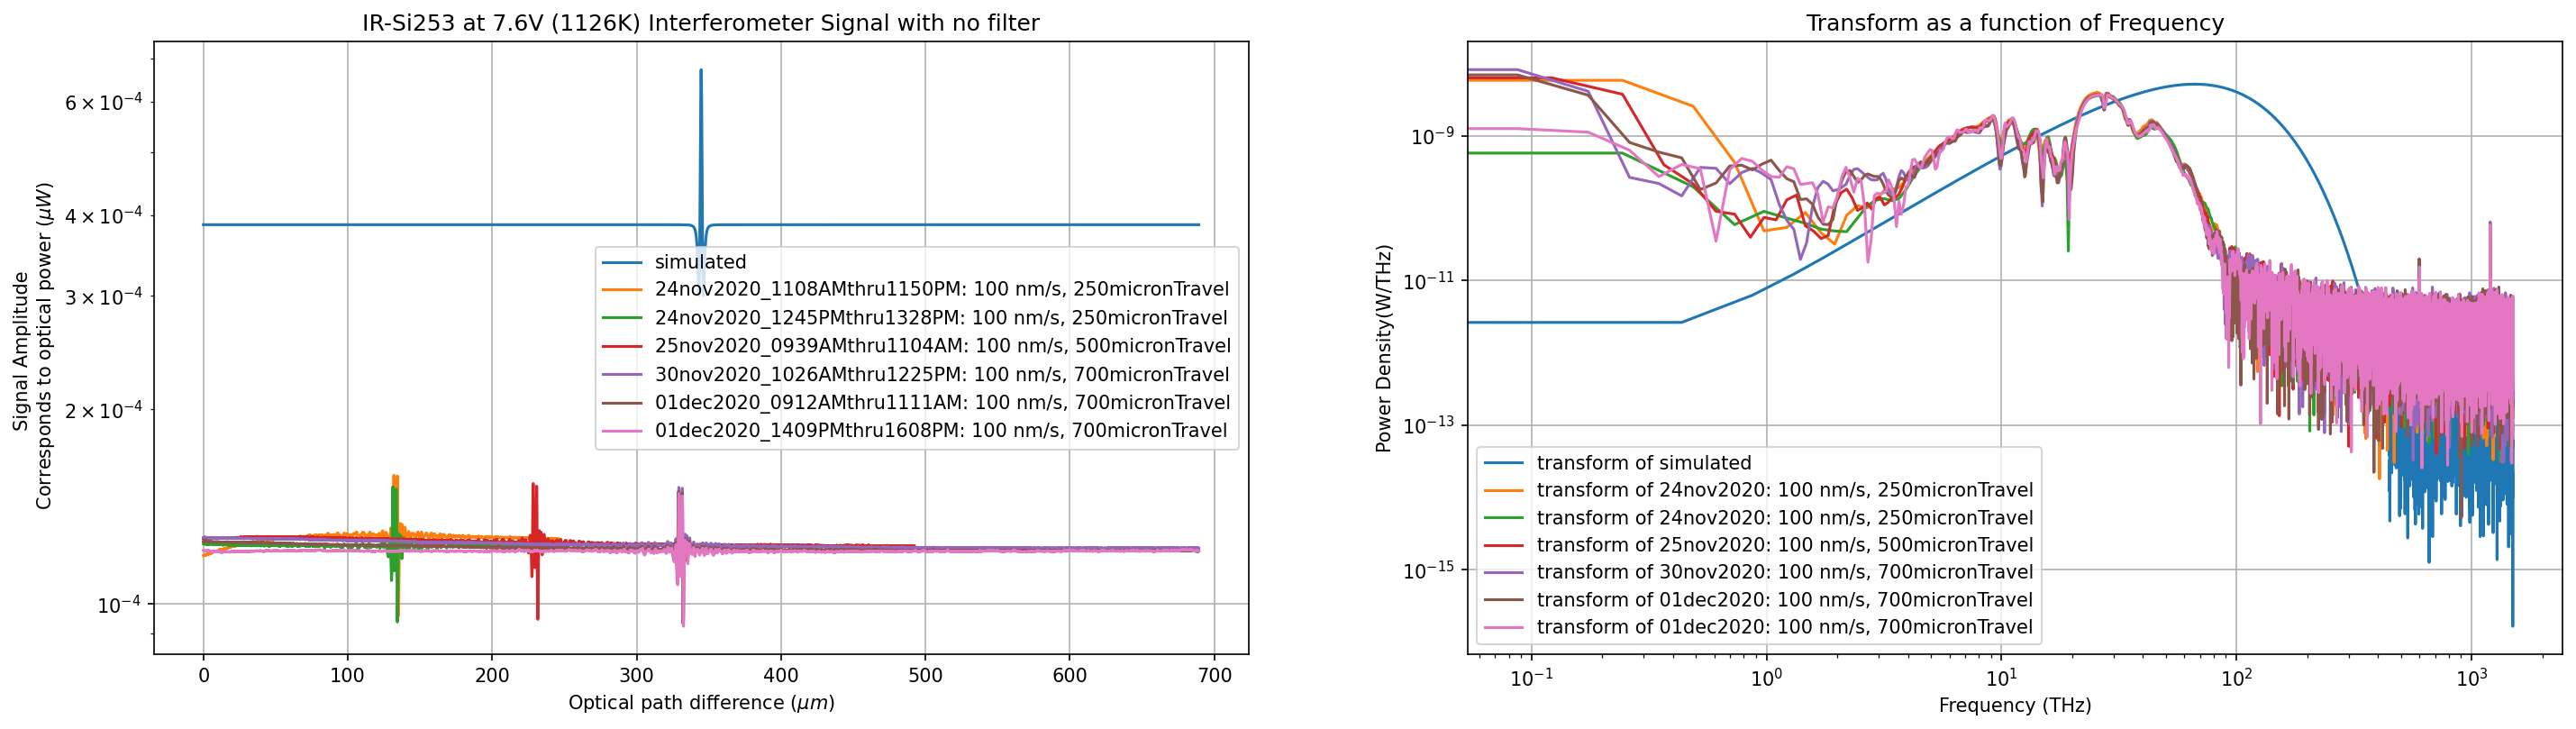

In [89]:
selected_volt = 7.6
source = "IR-Si253"
filt = "no"
plot_sim = True

plot_data(selected_volt, source, filt, plot_simulation = plot_sim, scale_weight = 5e-2, add_weight = 1e-4)

Plots with PEW Filter

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


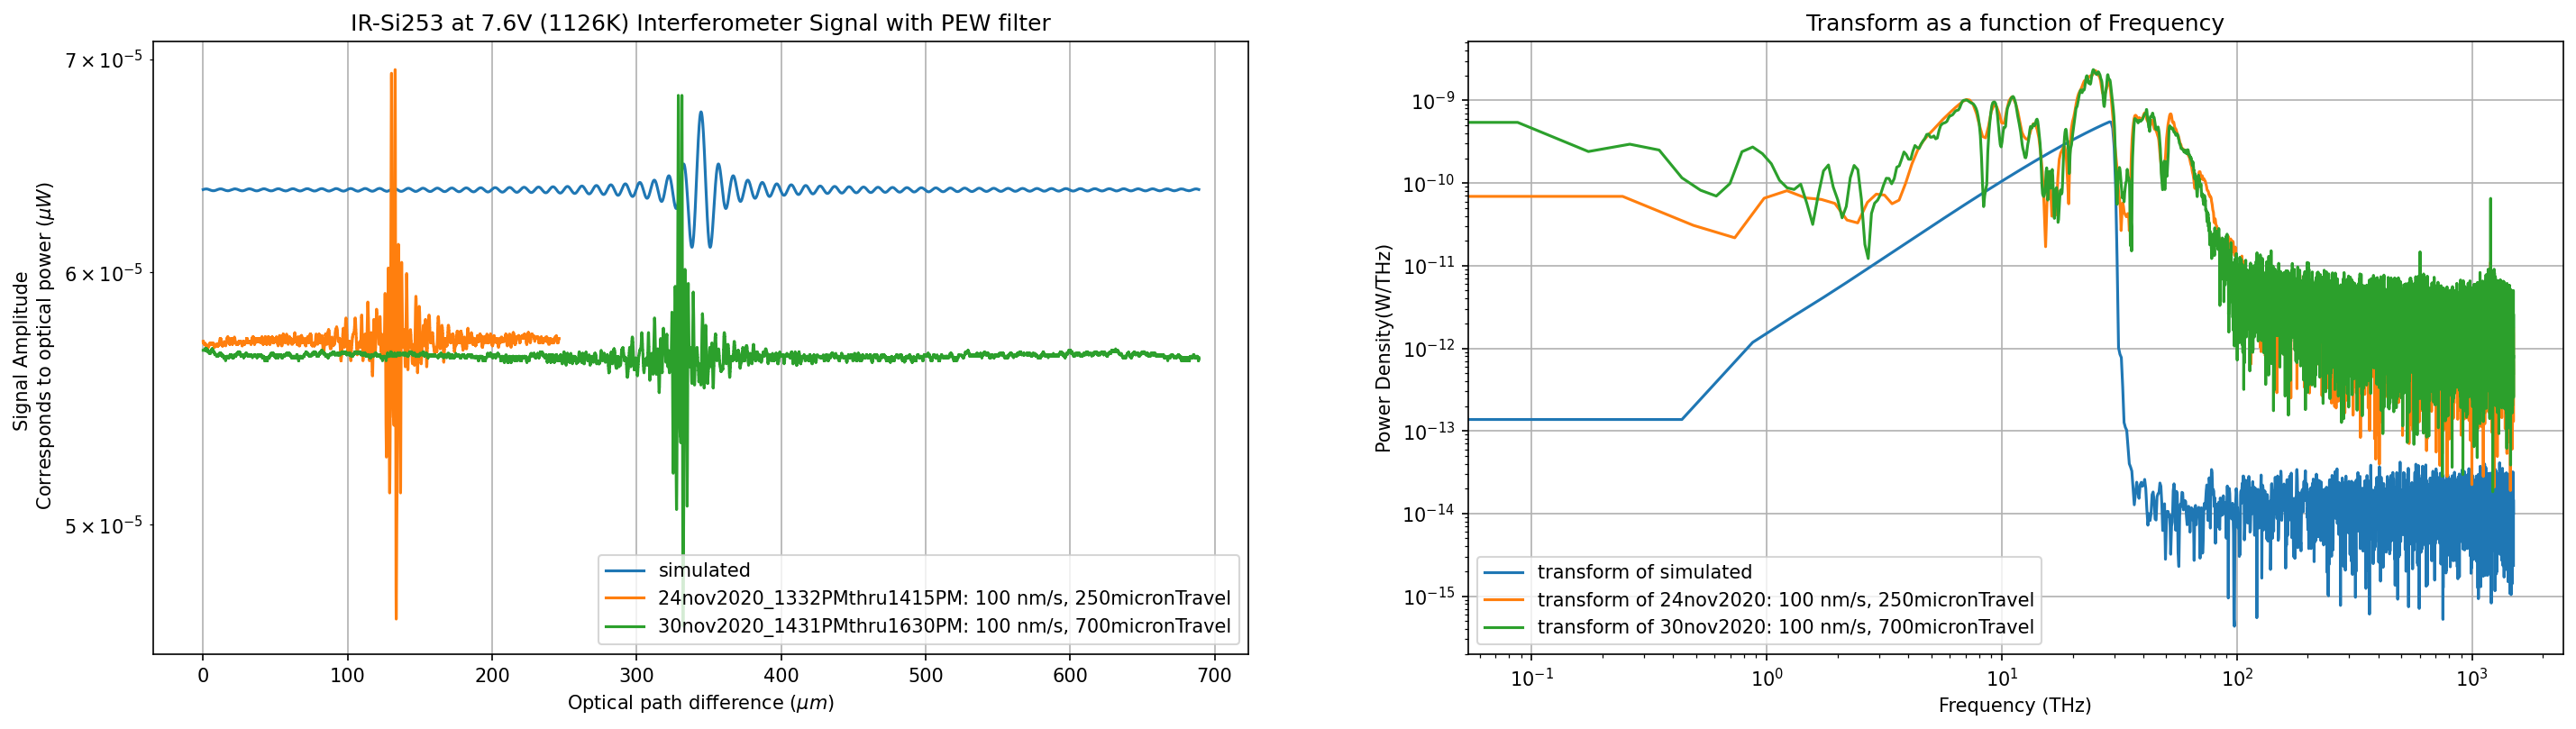

the mirror velocity for  24nov2020_1332PMthru1415PM: IR-Si253 PEWFilter (7.6V, 1.39A, 100 nm/s, 250micronTravel)   is  100.0
the mirror velocity for  30nov2020_1431PMthru1630PM: IR-Si253 PEWFilter (7.6V, 1.39A, 100 nm/s, 700micronTravel)   is  100.0


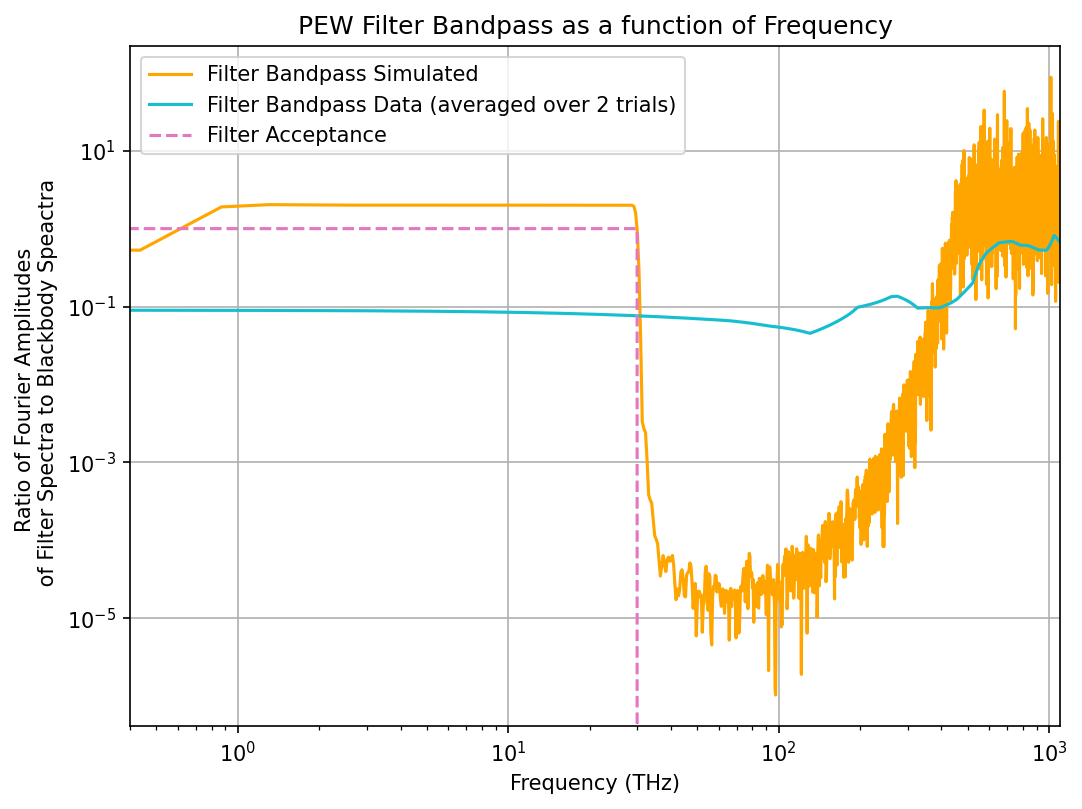

In [90]:
selected_volt = 7.6
source = "IR-Si253"
filt = "PEW"

plot_data(selected_volt, source, filt, plot_simulation = True, bandpass = True, scale_weight = 1e-2, add_weight = 6e-5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


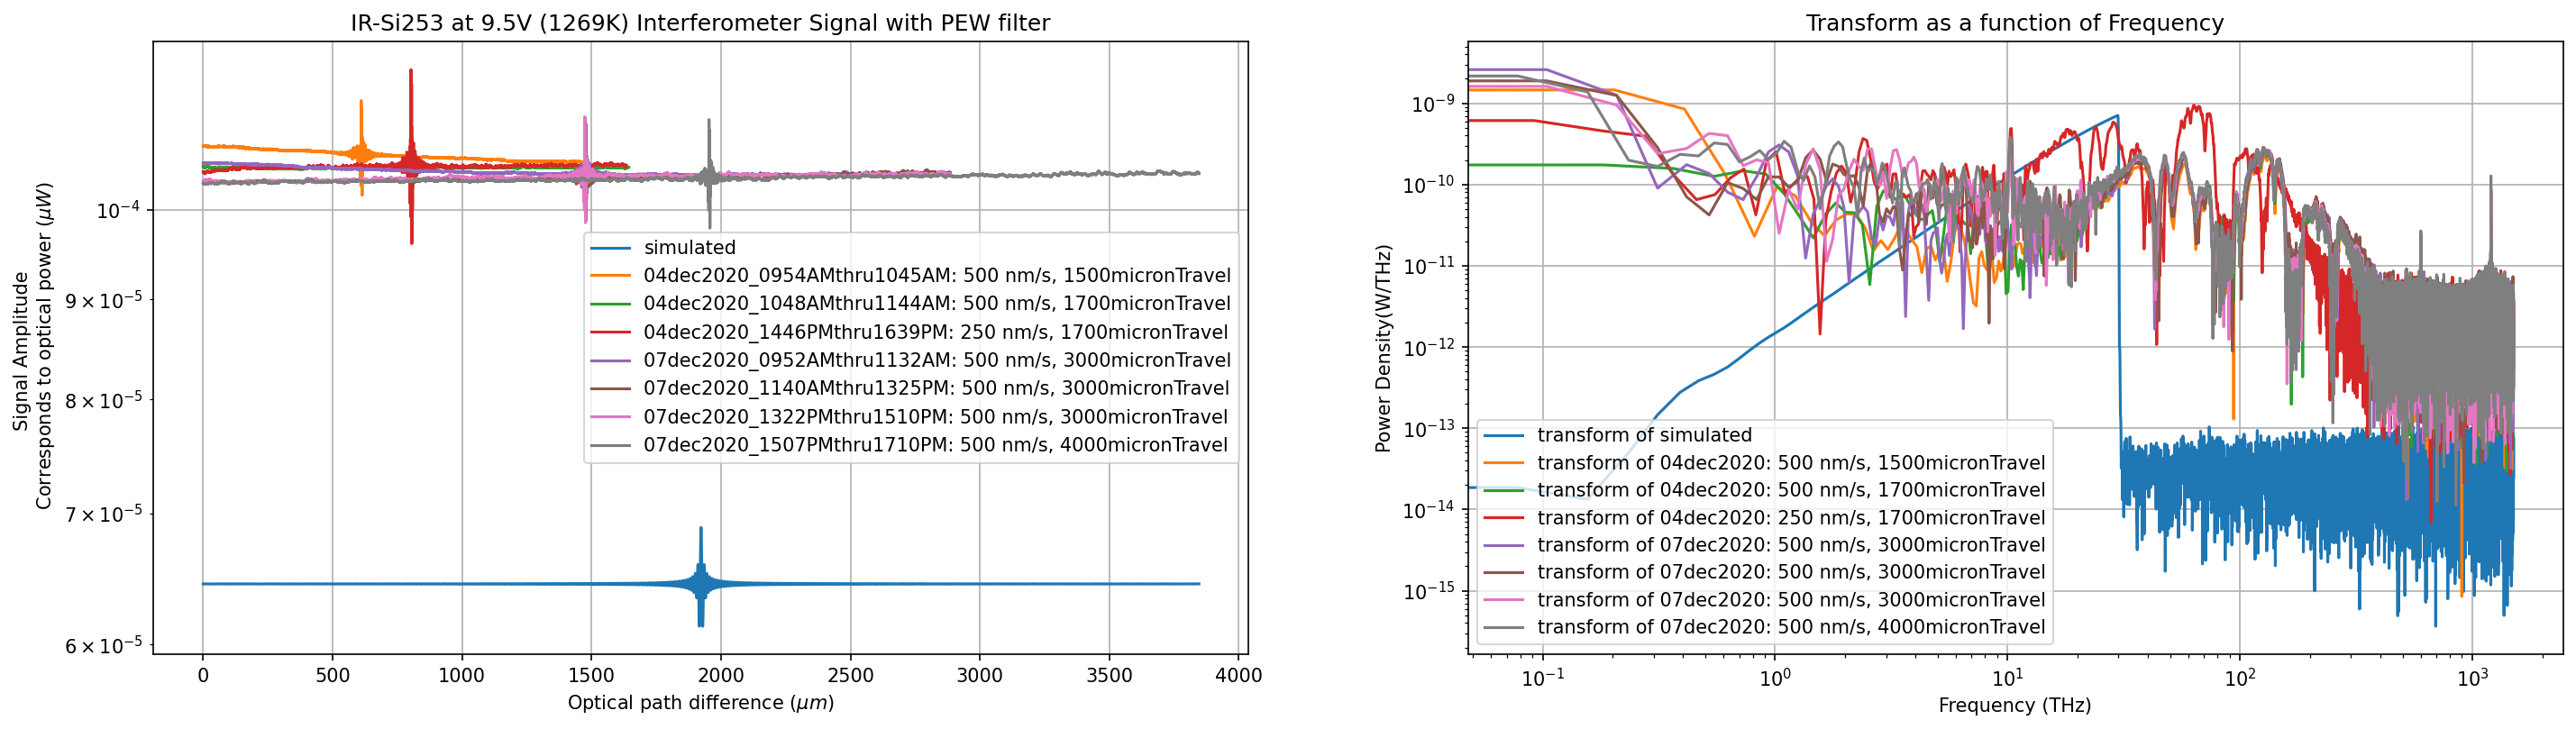

the mirror velocity for  04dec2020_0954AMthru1045AM: IR-Si253 PEWFilter (9.5V, 1.46A, 500 nm/s, 1500micronTravel)   is  500.0
the mirror velocity for  04dec2020_1048AMthru1144AM: IR-Si253 PEWFilter (9.5V, 1.46A, 500 nm/s, 1700micronTravel)   is  500.0
the mirror velocity for  04dec2020_1446PMthru1639PM: IR-Si253 PEWFilter (9.5V, 1.46A, 250 nm/s, 1700micronTravel)   is  250.0
the mirror velocity for  07dec2020_0952AMthru1132AM: IR-Si253 PEWFilter (9.5V, 1.46A, 500 nm/s, 3000micronTravel)   is  500.0
the mirror velocity for  07dec2020_1140AMthru1325PM: IR-Si253 PEWFilter (9.5V, 1.46A, 500 nm/s, 3000micronTravel)   is  500.0
the mirror velocity for  07dec2020_1322PMthru1510PM: IR-Si253 PEWFilter (9.5V, 1.46A, 500 nm/s, 3000micronTravel)   is  500.0
the mirror velocity for  07dec2020_1507PMthru1710PM: IR-Si253 PEWFilter (9.5V, 1.46A, 500 nm/s, 4000micronTravel)   is  500.0


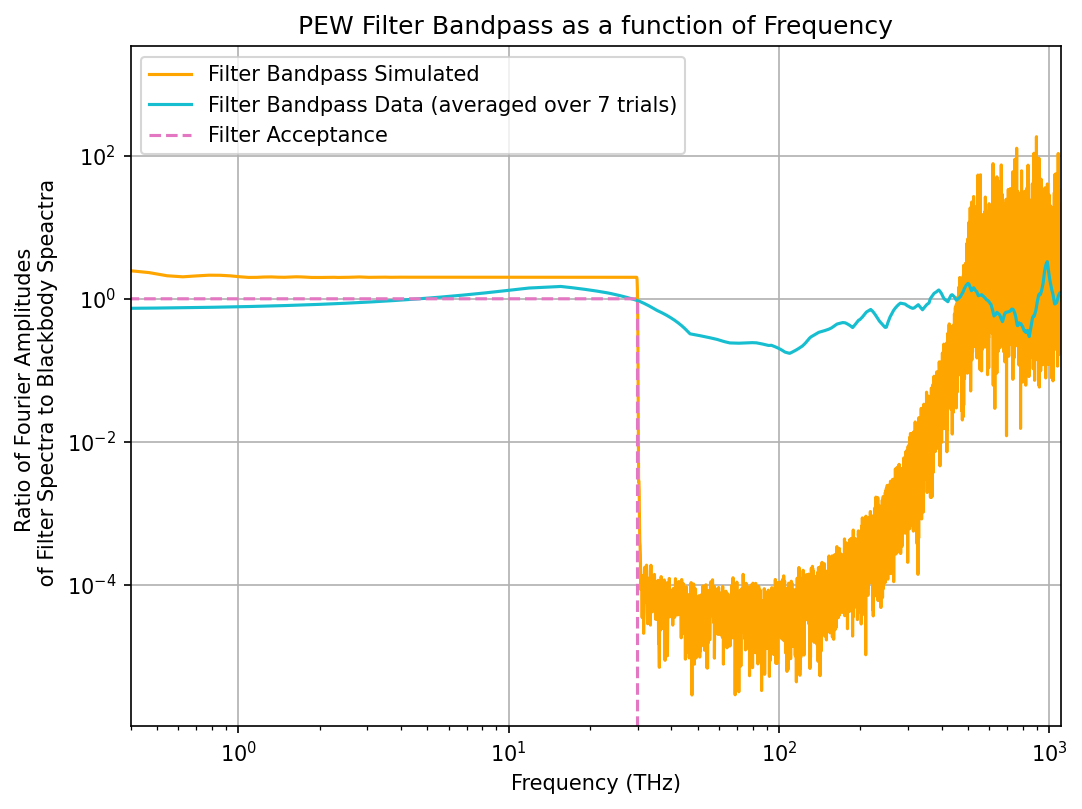

In [91]:
selected_volt = 9.5
source = "IR-Si253"
filt = "PEW"

plot_data(selected_volt, source, filt, plot_simulation = True, bandpass = True, scale_weight = 1e-2, add_weight = 6e-5)

Plots with SiW Filter

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


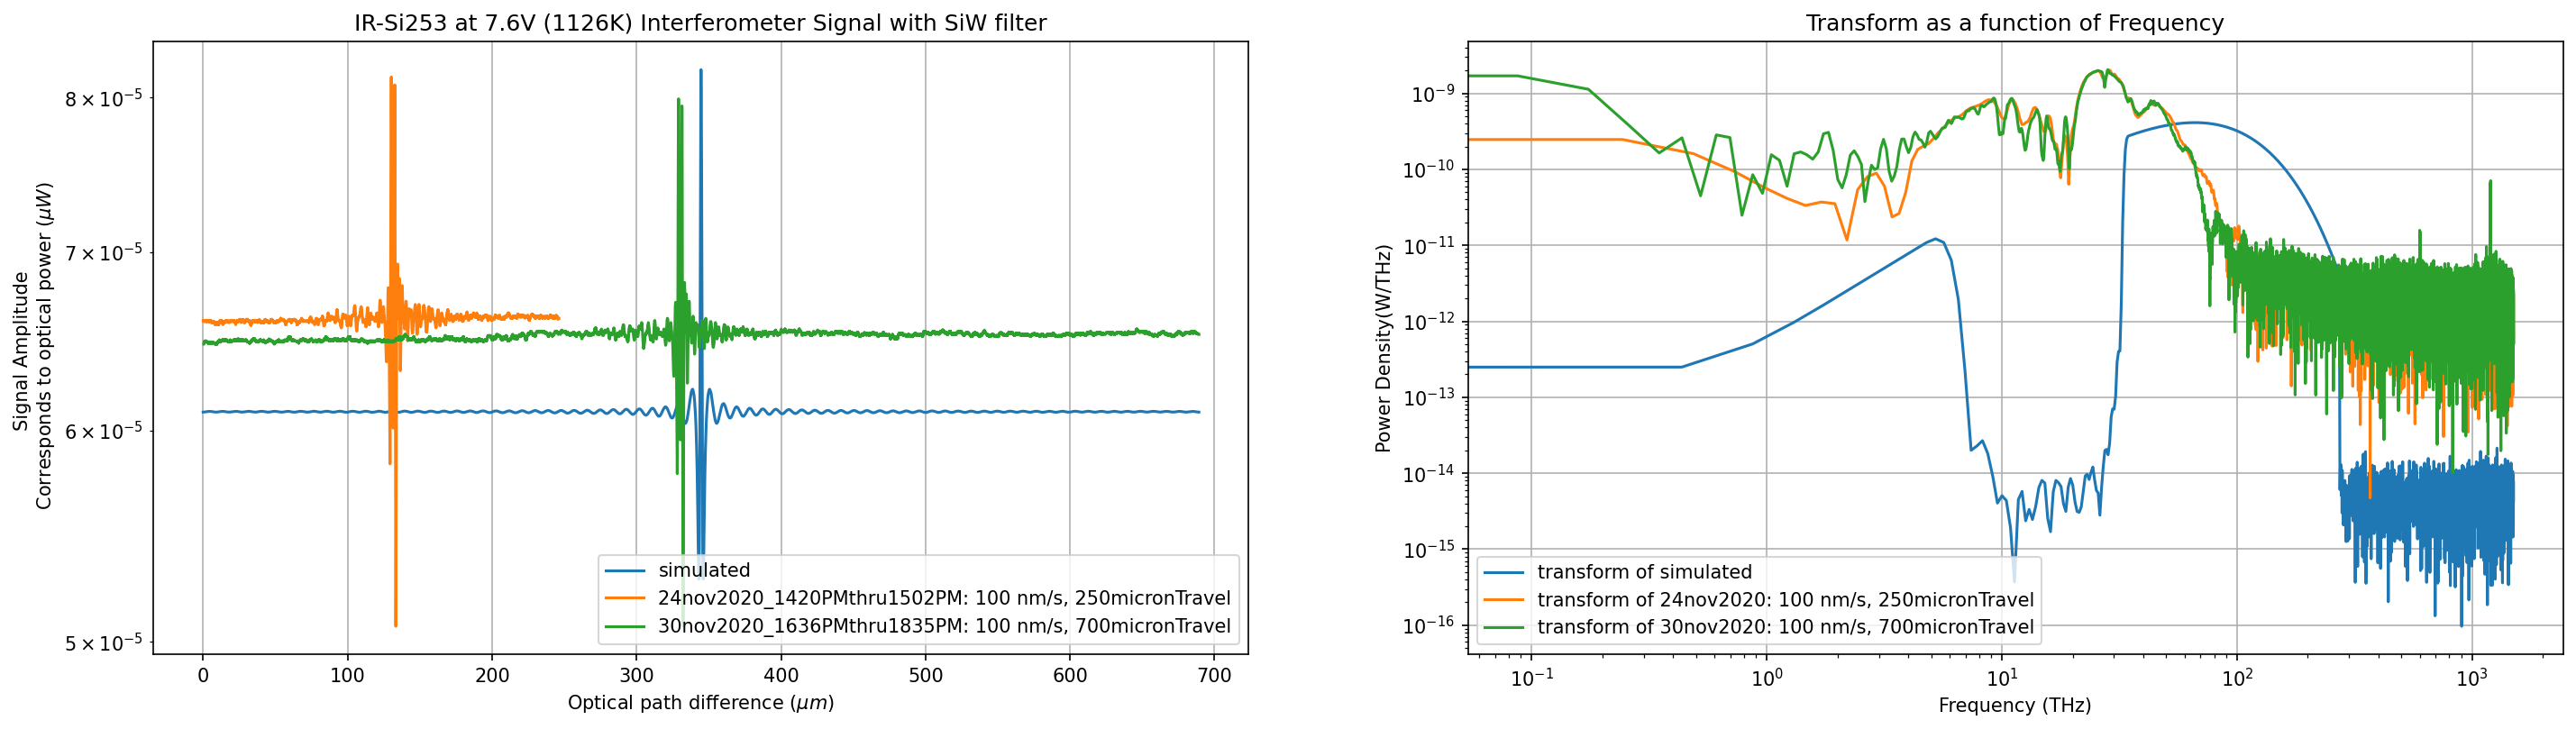

the mirror velocity for  24nov2020_1420PMthru1502PM: IR-Si253 SiWFilter (7.6V, 1.39A, 100 nm/s, 250micronTravel)   is  100.0
the mirror velocity for  30nov2020_1636PMthru1835PM: IR-Si253 SiWFilter (7.6V, 1.39A, 100 nm/s, 700micronTravel)   is  100.0


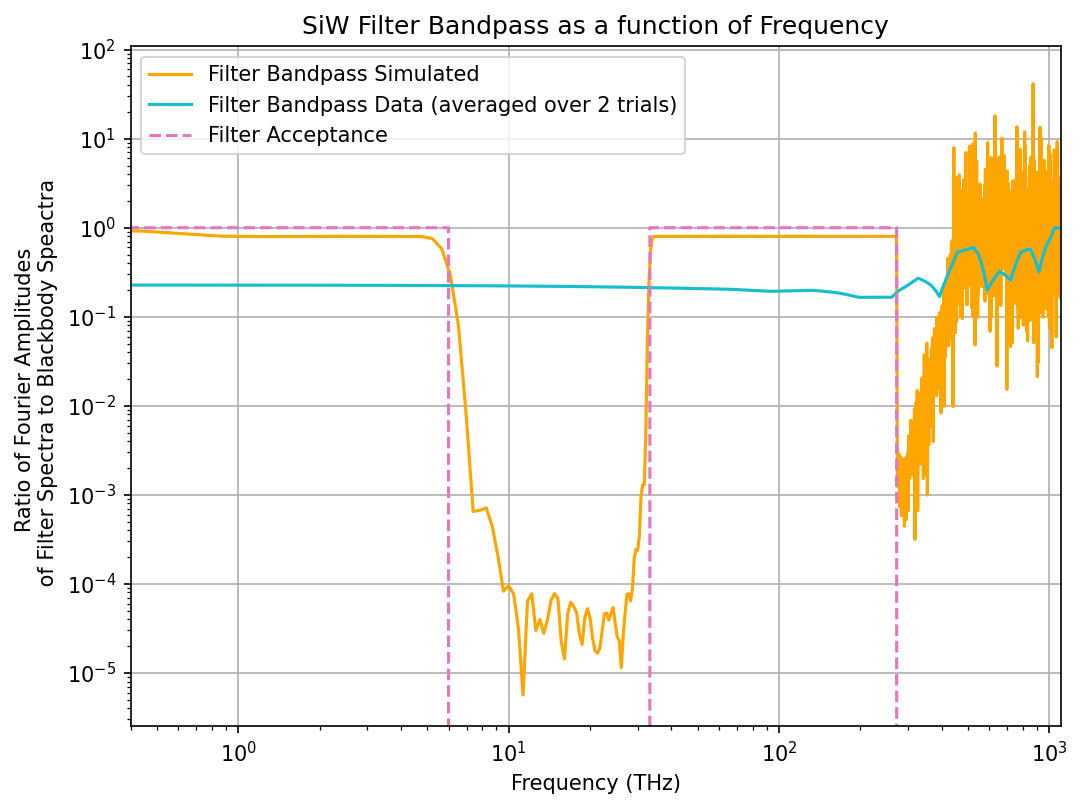

In [92]:
selected_volt = 7.6
source = "IR-Si253"
filt = "SiW"
plot_sim = True

plot_data(selected_volt, source, filt, plot_simulation = plot_sim, bandpass = True, scale_weight = 4e-3, add_weight = 4e-5)

In [ ]:
selected_volt = 9.5
source = "IR-Si253"
filt = "SiW"
plot_sim = True

plot_data(selected_volt, source, filt, plot_simulation = plot_sim, bandpass = True, scale_weight = 4e-3, add_weight = 4e-5)

Plot with Plastic Bag Filter

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


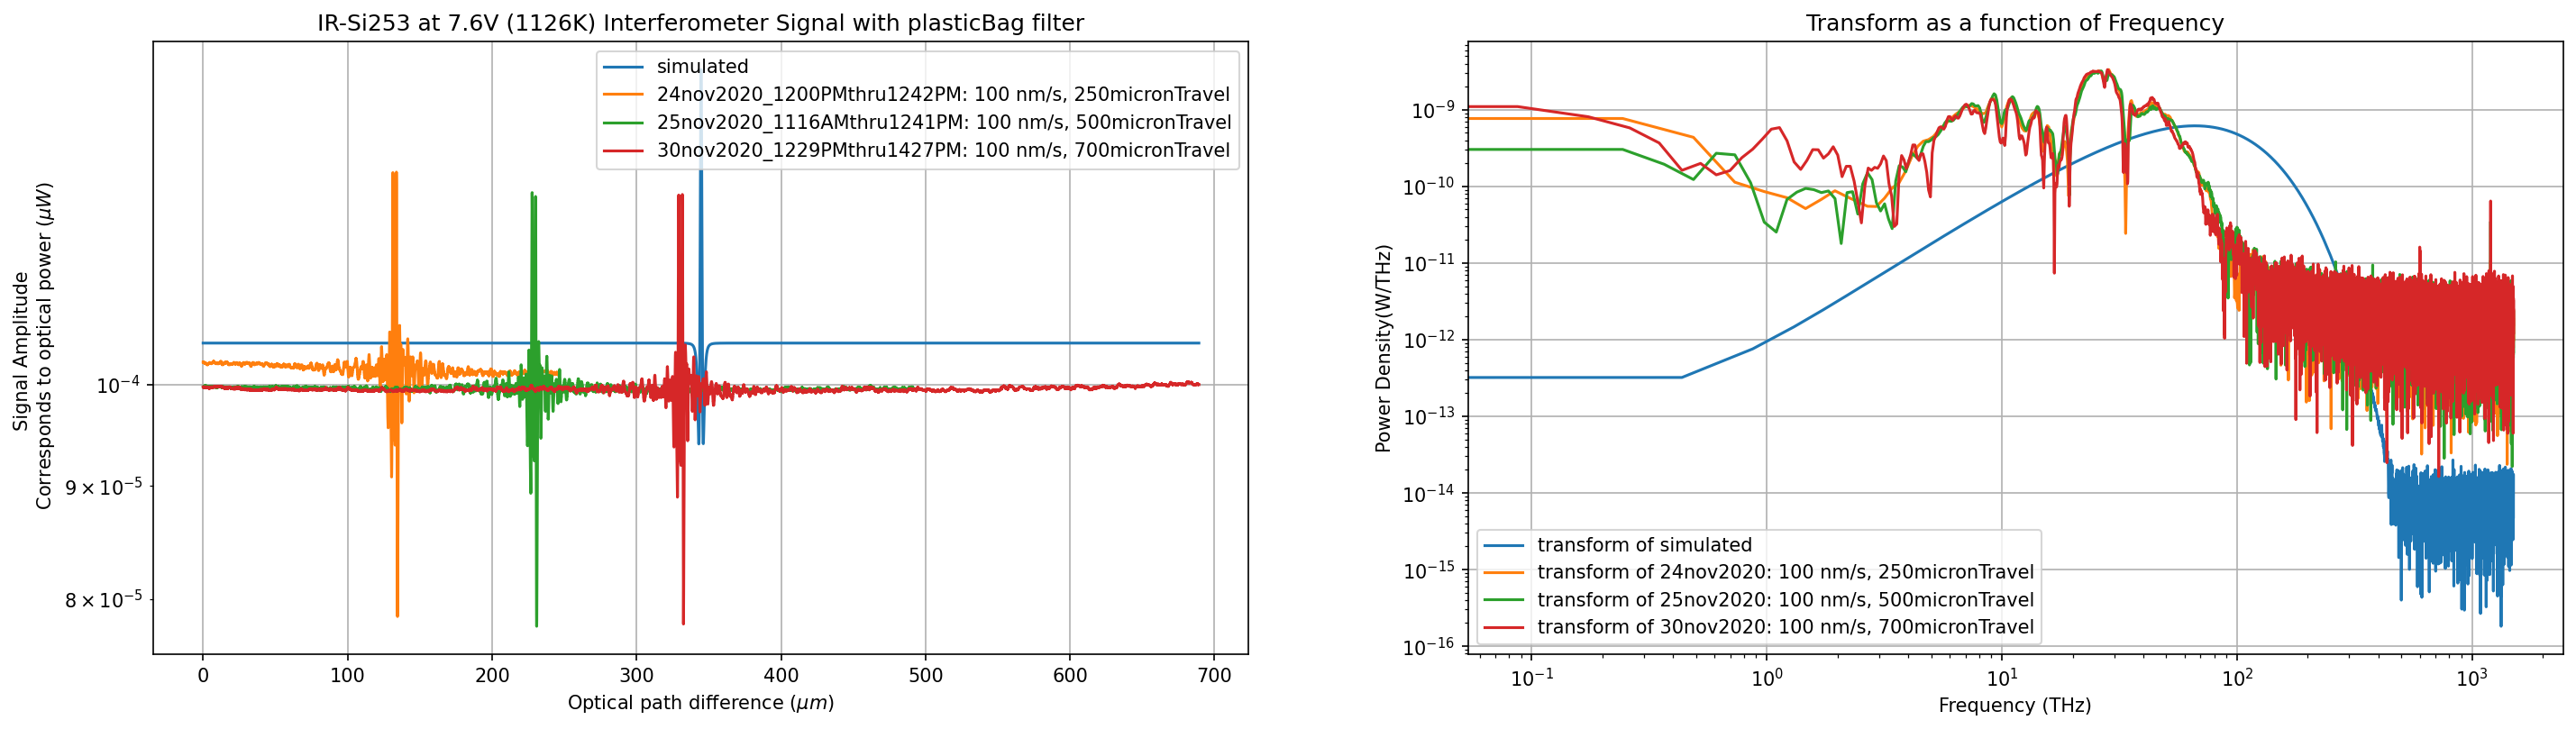

In [94]:
selected_volt = 7.6
temp = get_temp(selected_volt)
source = "IR-Si253"
filt = "plasticBag"
plot_sim = True

plot_data(selected_volt,source, filt, plot_simulation = plot_sim, scale_weight = 6e-3, add_weight = 7e-5)

Plot Double Plastic Bag Filter

In [ ]:
selected_volt = 7.6
source = "IR-Si253"
filt = "DoublePlasticBag"
plot_sim = True

plot_data(selected_volt, source, filt, plot_simulation = plot_sim, scale_weight = 6e-3, add_weight = 7e-5)

Plot 1650nm banpass filter

In [ ]:
selected_volt = 10.6
source = "IR-Si253"
filt = "1650nmBandpass"
plot_sim = True

plot_data(selected_volt, source, filt, plot_simulation = plot_sim, bandpass = False, scale_weight = 4e-3, add_weight = 4e-9)

Plot 1000nm banpass filter

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


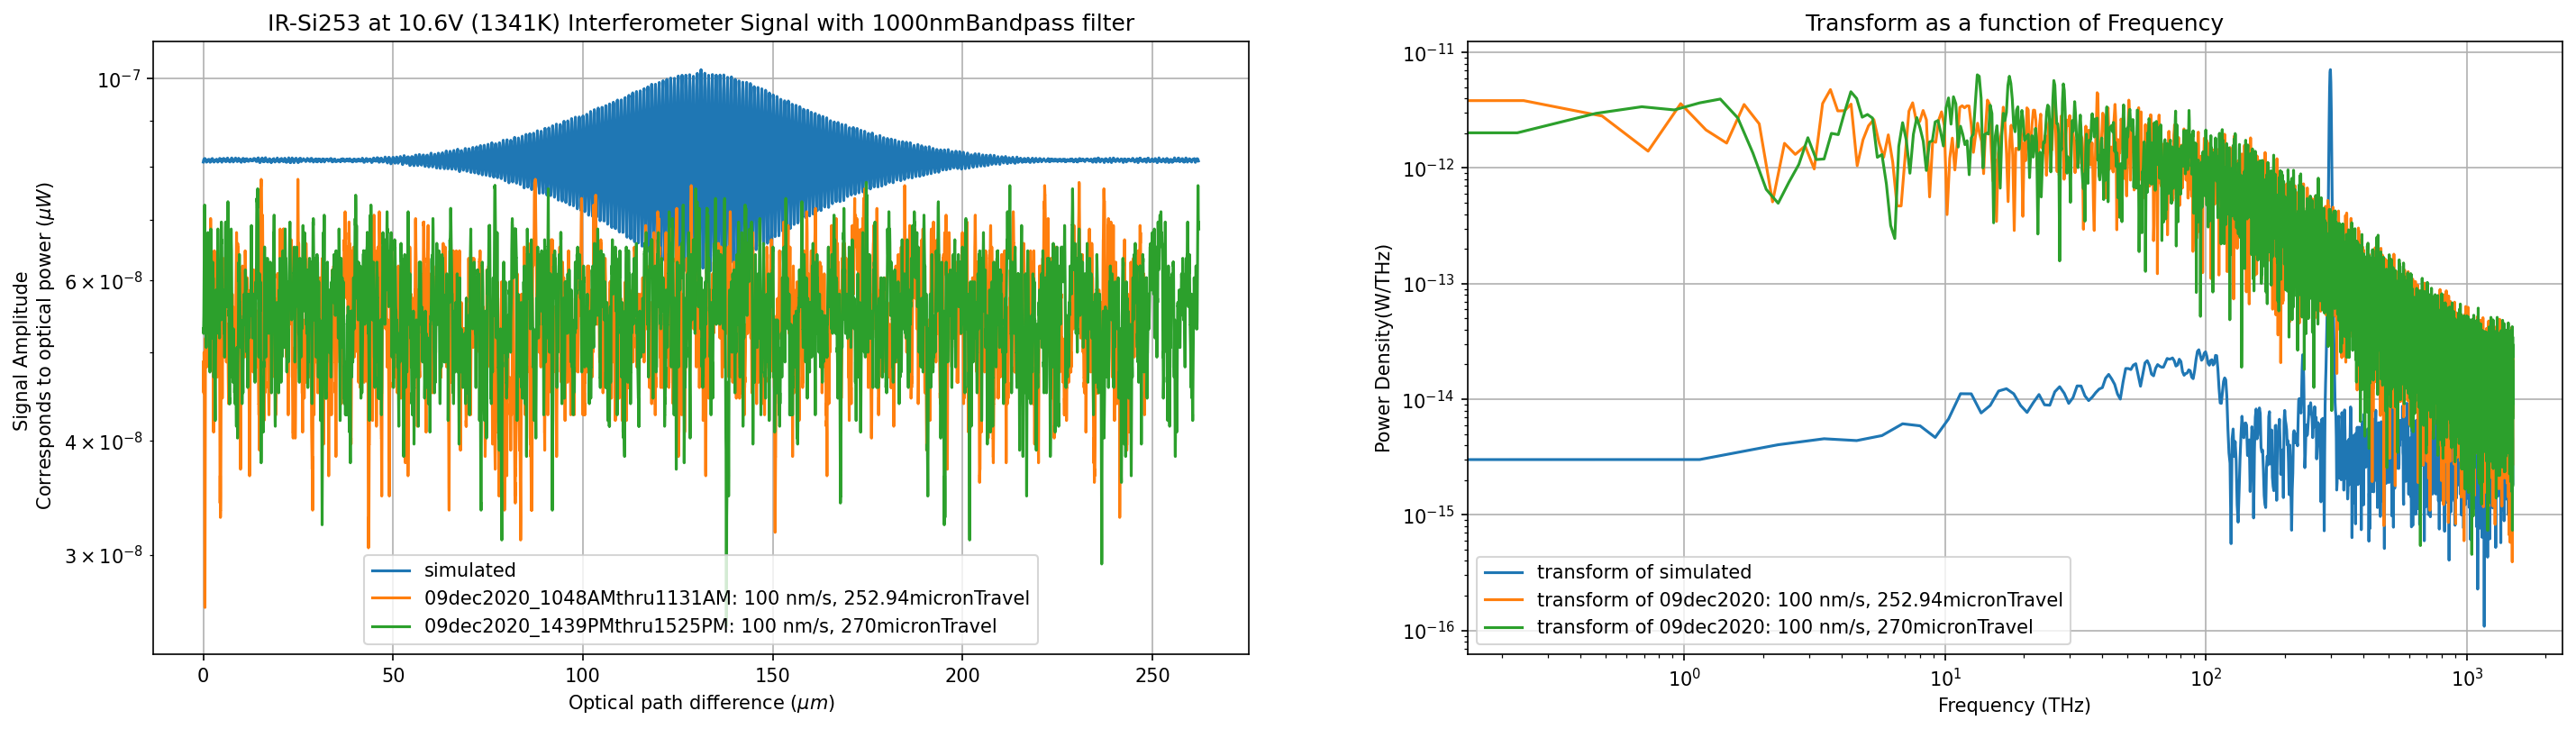

In [97]:
selected_volt = 10.6
source = "IR-Si253"
filt = "1000nmBandpass"
plot_sim = True


plot_data(selected_volt, source, filt, plot_simulation = plot_sim, bandpass = False, scale_weight = 5e-3, add_weight = 6e-8)